# **Emotion Analysis from Speech 🗣️🔊**

 <img src="https://i.postimg.cc/3JWFBr4P/20250517-0126-Speech-Emotion-Analysis-Design-remix-01jvdk8c03ev3r5g9gd2hggp5p.png" width="100%">

# Library Imports and Configuration

**Description: Imports essential libraries for audio processing, data manipulation, machine learning, and suppresses warnings.**

In [5]:
import os
import numpy as np
np.complex = complex
import pandas as pd
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
warnings.filterwarnings("ignore")

# Emotion Label Mapping
**Description: Dictionary that maps emotion codes to their corresponding emotion names.**

In [6]:
emotions_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


# Extract Emotion from Filename
**Description: Function to retrieve the emotion label from a structured filename using the predefined emotion mapping**

In [7]:
def extract_emotion_from_filename(filename):
    parts = filename.split('-')
    if len(parts) > 2:
        emotion_code = parts[2]
        return emotions_map.get(emotion_code)
    return None

# Audio Feature Extraction and Labeling
**Description: Extracts audio features from .wav files with noise augmentation, maps them to emotions, and stores them for model training.**

In [8]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, res_type='kaiser_fast')

    # Augmentation: add noise
    noise = np.random.randn(len(y))
    y = y + 0.005 * noise

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)

    return np.hstack([mfcc, chroma, zcr, contrast, tonnetz])

DATA_PATH = "D:\LEVEL_3\second_Term\Speech Recognition\project1\Audio_Speech_Actors_01-24"

features = []
labels = []

if not os.path.isdir(DATA_PATH):
    raise ValueError(f"Path {DATA_PATH} does not exist. Please check the path.")

for root, _, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            emotion = extract_emotion_from_filename(file)
            if emotion:
                try:
                    extracted = extract_features(file_path)
                    features.append(extracted)
                    labels.append(emotion)
                except Exception as e:
                    print(f"Error in file {file_path}: {e}")

if len(features) == 0:
    raise ValueError("No audio files found or features could not be extracted.")

# Data Preparation
**Description: Converts extracted features and encoded emotion labels into NumPy arrays for model input.**

In [9]:
X = np.array(features)
y = LabelEncoder().fit_transform(labels)

**Feature Distribution Across Emotions**<br>
Description:
Visualizes how a key audio feature (MFCC) varies between different emotions

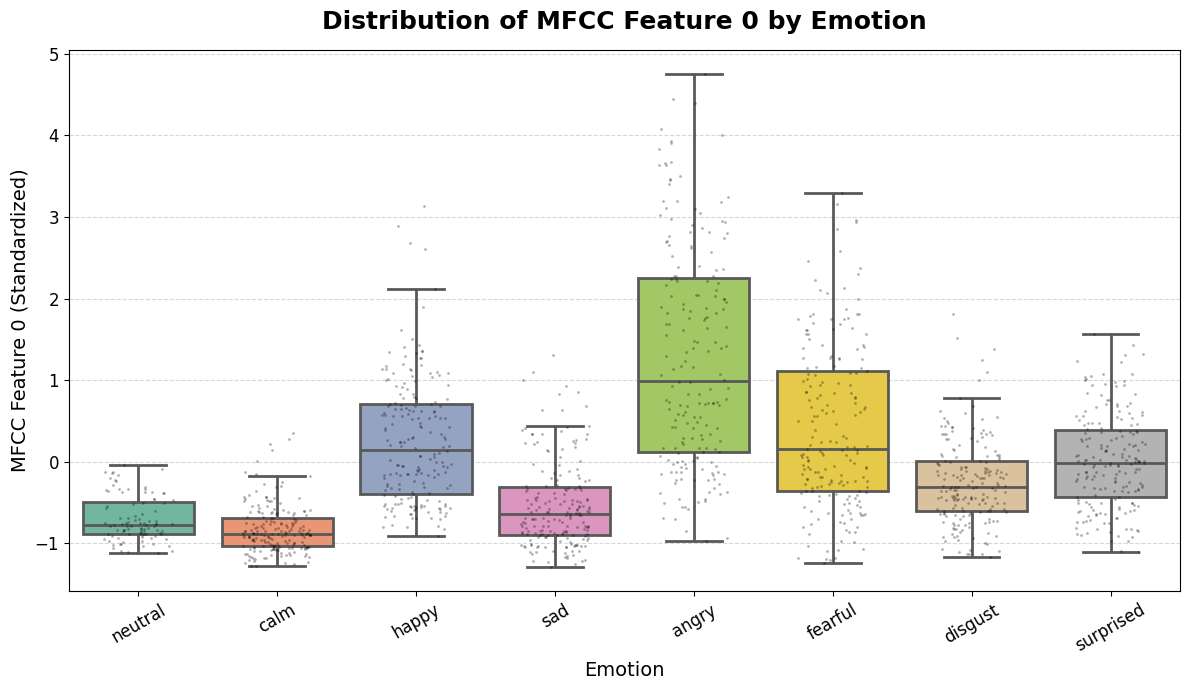

In [44]:

plt.figure(figsize=(12,7))
sns.boxplot(
    x='emotion', 
    y='feat_0', 
    data=df_features, 
    palette='Set2', 
    showfliers=False, 
    linewidth=2
)
sns.stripplot(
    x='emotion', 
    y='feat_0', 
    data=df_features, 
    color='black', 
    size=2, 
    jitter=0.25, 
    alpha=0.3
)
plt.title('Distribution of MFCC Feature 0 by Emotion', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('MFCC Feature 0 (Standardized)', fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Number of Samples per Emotion**<br>
Description:
Shows the count of audio samples available for each emotion category.

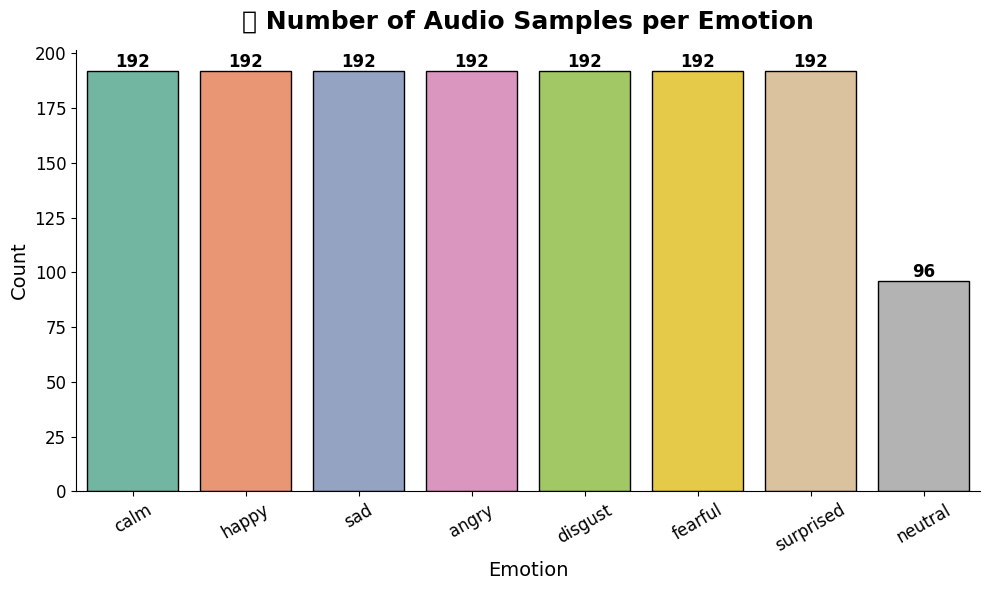

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(
    x='emotion',
    data=df_features,
    order=df_features['emotion'].value_counts().index,
    palette='Set2',
    edgecolor='black'
)
plt.title(' Number of Audio Samples per Emotion', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

sns.despine()
plt.tight_layout()
plt.show()


# Data Overview
**Description: Displays the number of samples, number of features, and a preview of the feature data.**

In [ ]:
print(f"Number of samples: {X.shape[0]}, Number of features: {X.shape[1]}")
print(f"Sample data: {X[:2]}")

# Feature Scaling
**Description: Applies standardization to the feature data to normalize the input for machine learning models.**

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Correlation Heatmap of Audio Features**<br>
Description:
Displays correlations between extracted audio features to identify relationships.

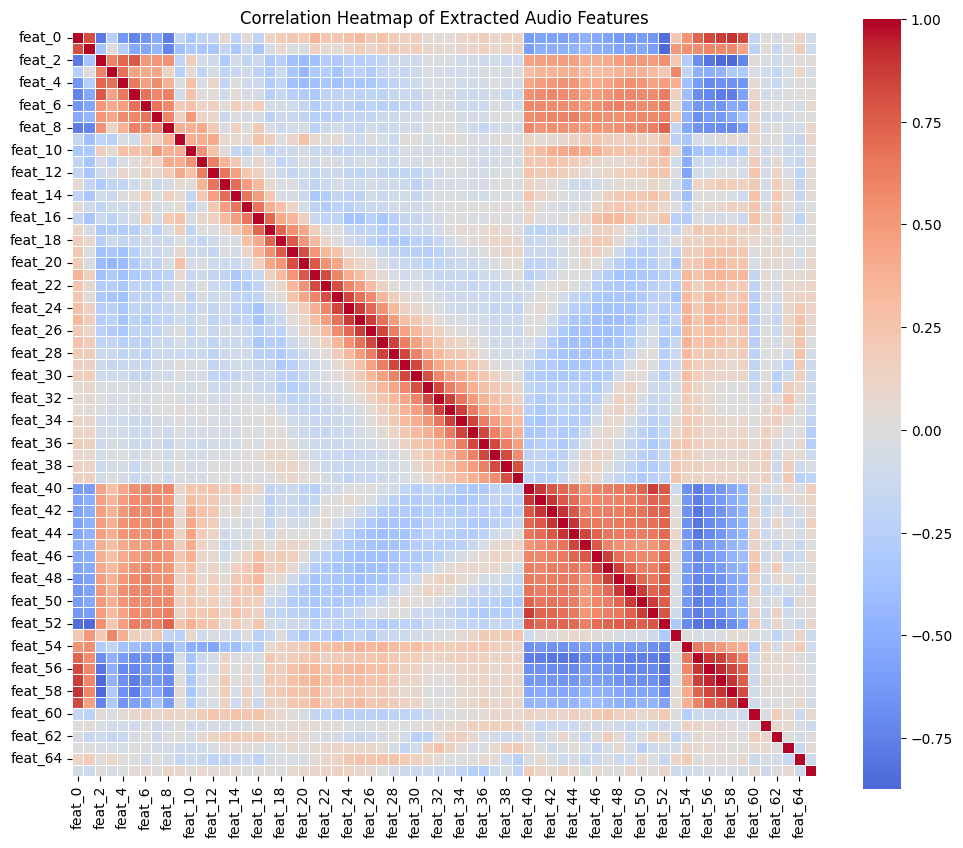

In [42]:
plt.figure(figsize=(12,10))
corr = df_features.drop('emotion', axis=1).corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5)
plt.title('Correlation Heatmap of Extracted Audio Features')
plt.show()


# Train-Test Split
**Description: Splits the dataset into training and testing sets with 20% reserved for testing.**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

# Model Training and Evaluation
**Description: Trains multiple classifiers, evaluates performance on the test set, and prints accuracy and classification reports.**

In [45]:
from sklearn.metrics import classification_report

# Use optimized hyperparameters for each model to improve accuracy
models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "SVM (Linear)": SVC(kernel='rbf', C=10),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski'),
    "Naive Bayes": GaussianNB()
}



results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"🚀 Training Model: {name}")
    print(f"{'-'*50}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
    results[name] = {
        "accuracy": acc,
        "report": report
    }
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"{'-'*50}")
    print("📋 Classification Report:\n")
    print(report)
    print(f"{'='*50}")


🚀 Training Model: Random Forest
--------------------------------------------------
✅ Accuracy: 56.94%
--------------------------------------------------
📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.79      0.62      0.69        42
        calm       0.55      0.86      0.67        44
     disgust       0.49      0.62      0.55        32
     fearful       0.61      0.69      0.65        32
       happy       0.38      0.32      0.35        34
     neutral       0.44      0.20      0.28        20
         sad       0.48      0.36      0.41        39
   surprised       0.69      0.64      0.67        45

    accuracy                           0.57       288
   macro avg       0.55      0.54      0.53       288
weighted avg       0.57      0.57      0.56       288


🚀 Training Model: SVM (Linear)
--------------------------------------------------
✅ Accuracy: 54.17%
--------------------------------------------------
📋 Classification

**Model Accuracy Comparison**<br>
Description:
Compares accuracy scores of different classifiers on the test dataset.

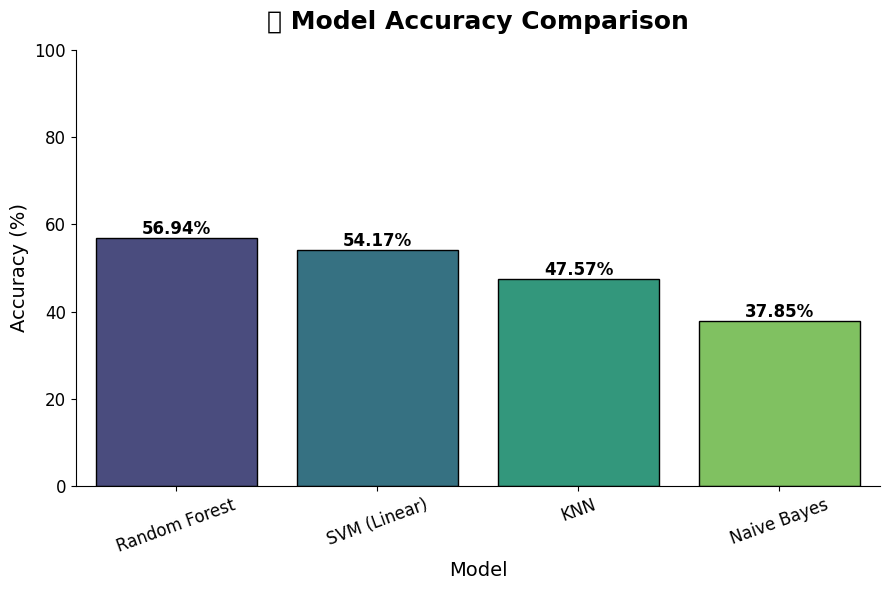

In [40]:
model_names = list(results.keys())
accuracies = [results[name]['accuracy']*100 for name in model_names]

plt.figure(figsize=(9,6))
bar = sns.barplot(x=model_names, y=accuracies, palette="viridis", edgecolor="black")
plt.title('🔬 Model Accuracy Comparison', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0, 100)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)

# Annotate bars with accuracy values
for p in bar.patches:
    bar.annotate(f"{p.get_height():.2f}%", 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

sns.despine()
plt.tight_layout()
plt.show()


# Model Performance Summary
**Description: Prints a concise comparison of accuracy scores for all trained models.**

In [37]:

print("📊 Model Performance Comparison:")
print("============================")
for name, result in results.items():
    print(f"{name:15} ➤ Accuracy: {round(result['accuracy'] * 100, 2)}%")

📊 Model Performance Comparison:
Random Forest   ➤ Accuracy: 56.94%
SVM (Linear)    ➤ Accuracy: 54.17%
KNN             ➤ Accuracy: 47.57%
Naive Bayes     ➤ Accuracy: 37.85%


**Confusion Matrix per Model**<br>
Description:
Shows prediction errors and successes for each emotion class by model.

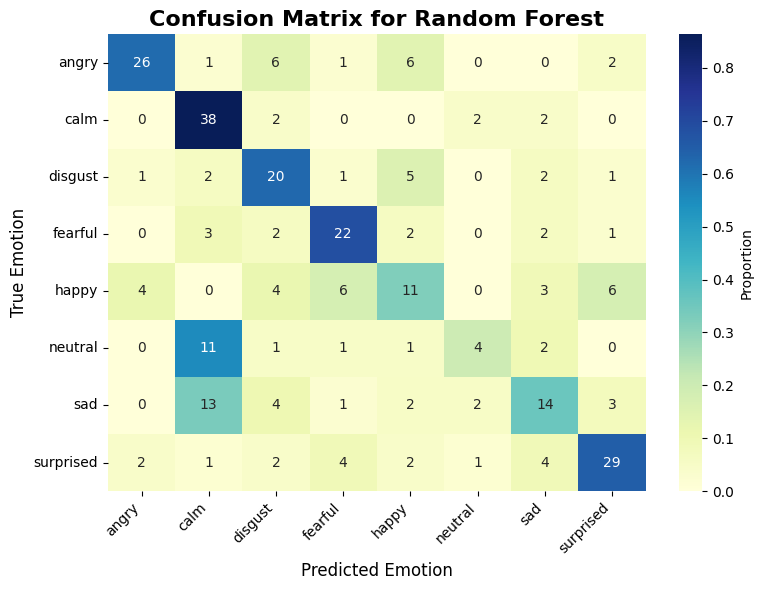

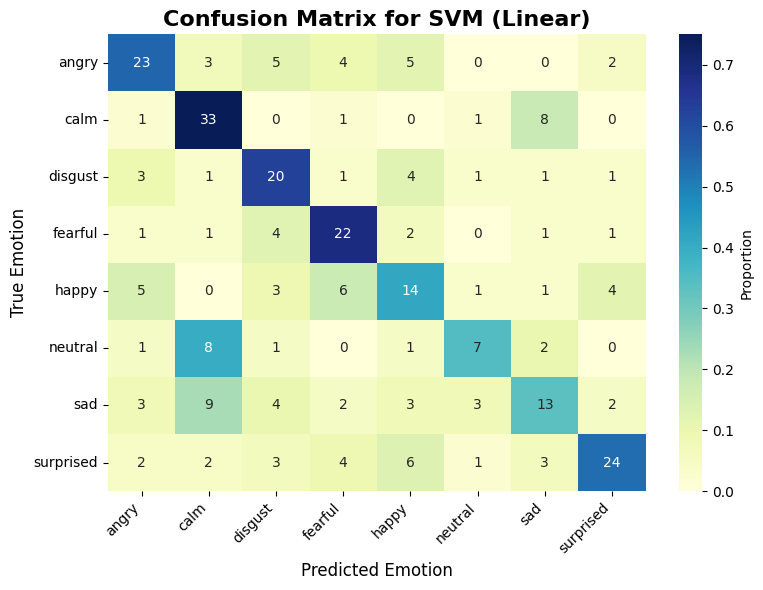

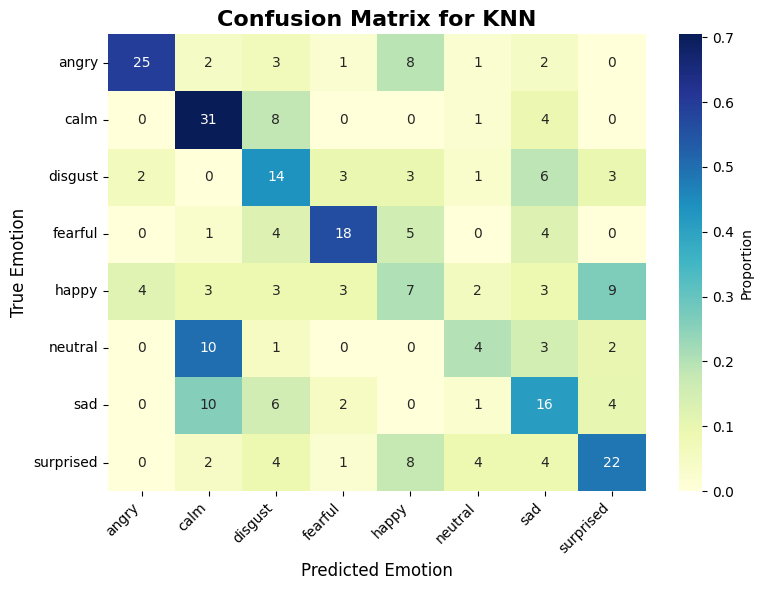

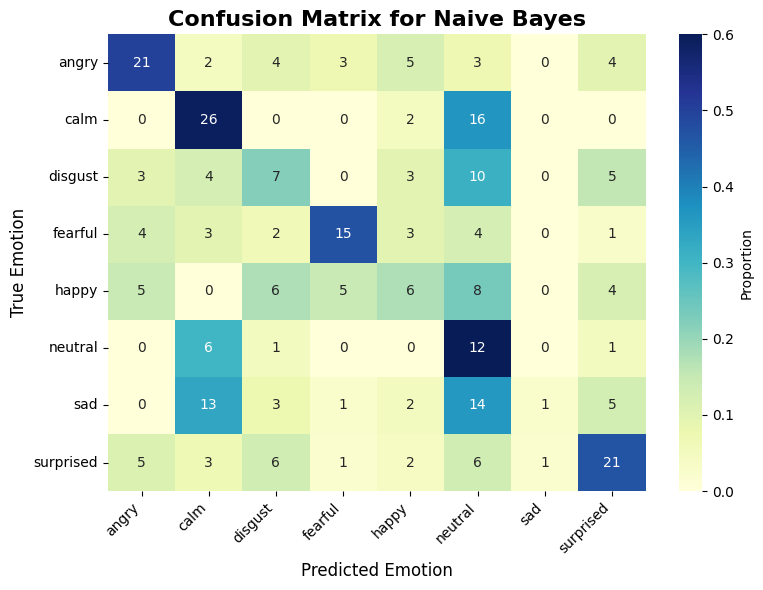

In [39]:
from sklearn.metrics import confusion_matrix

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm_norm, annot=cm, fmt='d', cmap='YlGnBu',
        xticklabels=le.classes_, yticklabels=le.classes_,
        cbar_kws={'label': 'Proportion'}
    )
    plt.title(f'Confusion Matrix for {name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Emotion', fontsize=12)
    plt.ylabel('True Emotion', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [46]:
import pickle

with open('random_forest_results.pkl', 'wb') as f:
    pickle.dump(results['Random Forest'], f)

